# 12. Claim frequency and severity modeling with GBM

### 12.1. Claim frequency modeling

* include the log of exposure as offset
* specify the poisson distribution for the target
* impose monotonically incresing contraint on ```bm```
* perform stochastic gradient boosting with ```max_depth = 3``` and ```learning_rate = 0.1```

In [1]:
# import relevant libraries
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import animation
import xgboost as xgb
import pandas as pd
import numpy as np
import random

In [2]:
# load data using separator to correctly parse from .txt
df = pd.read_csv(r'.\data\PC_data.txt', sep=r"\s+")

In [3]:
# column names to smaller case
df.columns = map(str.lower, df.columns)

In [4]:
# rename exp to expo
df.rename(columns={'exp':'expo'}, inplace = True); df.head()

,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,2,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,3,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,4,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,5,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


In [5]:
# converting type(str) columns to categorical
df['coverage'] = df['coverage'].astype('category').cat.codes
df['fleet'] = df['fleet'].astype('category').cat.codes
df['sex'] = df['sex'].astype('category').cat.codes
df['town'] = df['town'].astype('category').cat.codes
df['fuel'] = df['fuel'].astype('category').cat.codes
df['use'] = df['use'].astype('category').cat.codes

In [6]:
# cols to retain
cols = ['bm','ageph','agec','power','coverage','fuel','sex','fleet','use']

In [7]:
# let's calculate calculate claim frequency and weights
y = np.array(df.nclaims/df.expo)
w = np.array(df.expo)

In [8]:
# let's rearrange the dataset
x = np.array(df[cols])

In [55]:
xgb_model = xgb.XGBRegressor(n_estimators = 500, 
                              objective='count:poisson',
                              monotone_constraints = (1,0,0,0,0,0,0,0,0),
                              max_depth = 3,
                              learning_rate = 0.1)

xgb_model.fit(x,y,sample_weight = w)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0.699999988, max_depth=3,
             min_child_weight=1, missing=nan,
             monotone_constraints=(1, 0, 0, 0, 0, 0, 0, 0, 0), n_estimators=500,
             n_jobs=16, num_parallel_tree=1, objective='count:poisson',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [56]:
pred = xgb_model.predict(x)

In [57]:
test = pd.DataFrame({'obs':y,'pred':pred})

In [59]:
test

,obs,pred
0,1.000000,0.170218
1,0.000000,0.123541
2,0.000000,0.101210
3,0.000000,0.072803
4,21.470588,0.268706
...,...,...
163226,0.000000,0.167133
163227,0.000000,0.127110
163228,0.000000,0.115460
163229,0.000000,0.110145


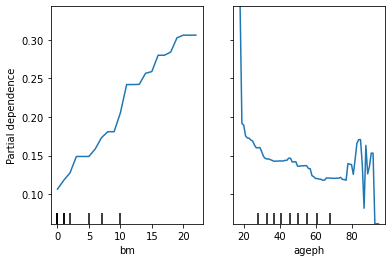

In [61]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(xgb_model, features = ['bm','ageph'], X=x, feature_names = ['bm','ageph'])

In [62]:
xgb_model.get_booster().feature_names = cols
xgb_model.get_booster().get_score(importance_type="gain")

{'bm': 37.15328734807098,
 'ageph': 3.1714233514930594,
 'fuel': 5.319156510664176,
 'agec': 2.0373651983735734,
 'power': 1.9949931282439737,
 'sex': 2.758214056225175,
 'coverage': 2.7172036055882334,
 'fleet': 1.584109418786842,
 'use': 1.1127357833026315}

<AxesSubplot:>

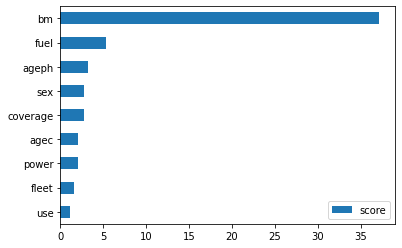

In [63]:
# feature importance
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')

In [64]:
# aggregate trees in a pd.DataFrame
xgb_model.get_booster().trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,bm,6.5,0-1,0-2,0-1,255.927734,146231.156000
1,0,1,0-1,bm,1.5,0-3,0-4,0-3,40.210938,116025.688000
2,0,2,0-2,bm,10.5,0-5,0-6,0-5,32.356445,30205.470700
3,0,3,0-3,ageph,55.5,0-7,0-8,0-7,13.670898,81035.437500
4,0,4,0-4,fuel,0.5,0-9,0-10,0-9,6.787109,34990.250000
...,...,...,...,...,...,...,...,...,...,...
6831,499,10,499-10,Leaf,NaN,NaN,NaN,NaN,0.055307,1.378483
6832,499,11,499-11,Leaf,NaN,NaN,NaN,NaN,0.022926,21.727396
6833,499,12,499-12,Leaf,NaN,NaN,NaN,NaN,-0.000382,8127.612300
6834,499,13,499-13,Leaf,NaN,NaN,NaN,NaN,0.000595,10542.572300


In [65]:
# dump model (direct access to each tree) and load it
xgb_model.get_booster().dump_model("./data/out.txt", with_stats=True)

# read the contents of the file
with open('./data/out.txt', 'r') as f:
    txt_model = f.read()
print(txt_model)

booster[0]:
0:[bm<6.5] yes=1,no=2,missing=1,gain=255.927734,cover=146231.156
	1:[bm<1.5] yes=3,no=4,missing=3,gain=40.2109375,cover=116025.688
		3:[ageph<55.5] yes=7,no=8,missing=7,gain=13.6708984,cover=81035.4375
			7:leaf=-0.0381389894,cover=49579.9375
			8:leaf=-0.0408193506,cover=31455.498
		4:[fuel<0.5] yes=9,no=10,missing=9,gain=6.78710938,cover=34990.25
			9:leaf=-0.0331041776,cover=11479.3447
			10:leaf=-0.0360973291,cover=23510.9043
	2:[bm<10.5] yes=5,no=6,missing=5,gain=32.3564453,cover=30205.4707
		5:[ageph<26.5] yes=11,no=12,missing=11,gain=9.27807617,cover=19862.8926
			11:leaf=-0.0265295003,cover=4825.41748
			12:leaf=-0.0312158596,cover=15037.4746
		6:[agec<6.5] yes=13,no=14,missing=13,gain=6.33276367,cover=10342.5791
			13:leaf=-0.0263584312,cover=3765.06372
			14:leaf=-0.0211947113,cover=6577.51514
booster[1]:
0:[bm<6.5] yes=1,no=2,missing=1,gain=256.447266,cover=141085.984
	1:[bm<2.5] yes=3,no=4,missing=3,gain=40.7861328,cover=111704.883
		3:[ageph<55.5] yes=7,no=8,mi